In [1]:
import sys
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

sys.path.append("..")
from geoobb.obb import geom_to_array, oriented_bounding_box

## Load Data


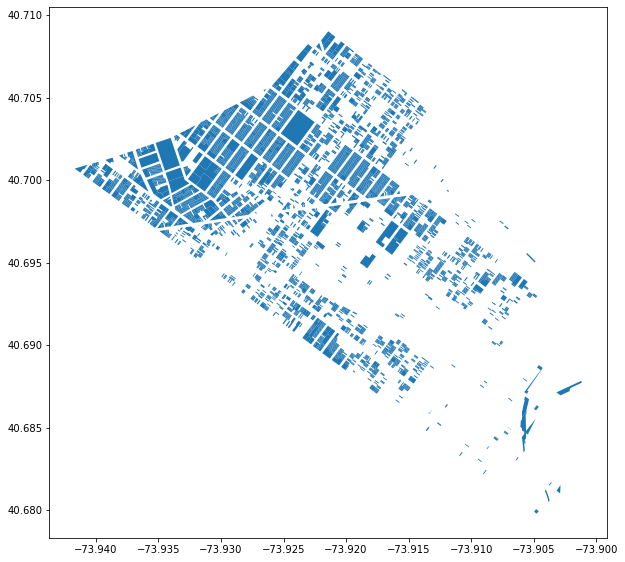

In [2]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson'
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)

gdf.plot(figsize=(10, 10));

In [3]:
# the api has a max record limit of 4000
len(gdf)

4000

## Generate OBBs


In [4]:
%timeit gdf.geometry.map(geom_to_array)

1 loop, best of 3: 636 ms per loop


In [5]:
geo_arrs = gdf.geometry.map(geom_to_array)
%timeit geo_arrs.map(oriented_bounding_box)

1 loop, best of 3: 1.1 s per loop


Performance: pretty fast for 4,000 geometries!


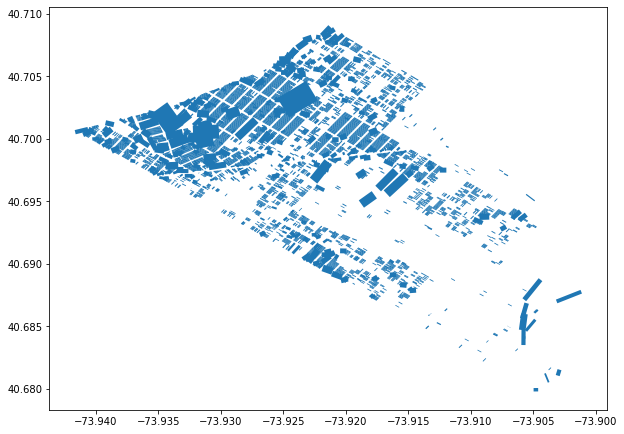

In [6]:
obbs = geo_arrs.map(oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(Polygon))
obbs_gs.plot(figsize=(10, 10));

## Determine Parcel Orientions


In [7]:
def find_long_edge_and_angle(box):
    distances = [np.linalg.norm(box[i] - box[(i + 1) % 4]) for i in range(4)]
    long_edge_index = np.argmax(distances)
    p1, p2 = box[long_edge_index], box[(long_edge_index + 1) % 4]
    long_edge_vector = p2 - p1
    angle = np.arctan2(long_edge_vector[1], long_edge_vector[0])
    angle_degrees = np.degrees(angle)

    return long_edge_vector, angle_degrees


In [8]:
long_edges, angles = np.array([find_long_edge_and_angle(obb) for obb in obbs]).T

/Users/raphaellaude/opt/anaconda3/envs/sde_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


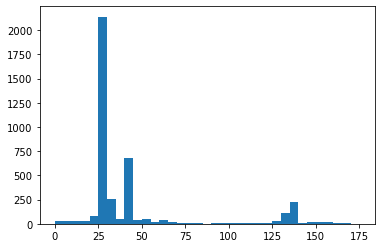

In [9]:
plt.hist(np.abs(angles), bins=np.arange(0, 180, 5));